In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My\ Drive/tobigs/snorrr2

/content/drive/My Drive/tobigs/snorrr2


In [0]:
# !unzip aug_data.zip -d data/
!pip install pydub

In [0]:
ls

 aug_data.zip                   new_snorrr.ipynb
 converted_model.tflite         new_snorrr_true_false.ipynb
 data/                          new_snorrr_true_false_light.ipynb
 data_aug/                      new_snorrr_true_false_light_keras.ipynb
 data_small/                    noise/
'Mobilenet_colab(aug ver)'      raw_data.zip
 Mobilenet_colab_eunsun.ipynb   temp.mp3
 Mobilenet_colab.ipynb          Untitled0.ipynb
 model/                         weight/


## audio.csv 만들기
(파일 겹치는건 빼기)

In [0]:
cd /content/drive/My\ Drive/tobigs/snorrr2/data

/content/drive/My Drive/tobigs/snorrr2/data


In [0]:
ls

'Male speech, man speaking'/   snoring/                         Vehicle/
'Outside, rural or natural'/  'Traffic noise, roadway noise'/


In [0]:
import pandas as pd
import os

label_info = ['Male speech, man speaking','Outside, rural or natural','snoring','Traffic noise, roadway noise','Vehicle']
df = pd.DataFrame({"file_name":[], "labels":[]})
for label in os.listdir():
  if label=='__MACOSX':
      continue
  label_dir = os.path.join(os.getcwd(), label)
  current_label_num = label_info.index(label)+1
  for file in os.listdir(label_dir):
    if file.endswith("mp3"):
      df = df.append({"file_name":file, "labels":int(current_label_num)} , ignore_index=True)

In [0]:
df.labels = df['labels'].astype(int)

In [0]:
df[df.file_name.duplicated()]['file_name']

82     3353.mp3
107    2550.mp3
112    2933.mp3
134    2762.mp3
147    1705.mp3
149    3272.mp3
157    2536.mp3
225    1522.mp3
Name: file_name, dtype: object

In [0]:
df[df['file_name'].str.find('5487.mp3')!=-1]

,file_name,labels
241,5487.mp3,1


In [0]:
# 중복되는건 삭제하기
df = df[df['file_name'].isin(df[df.file_name.duplicated()]['file_name'])==False]

In [0]:
len(df)

227

In [0]:
df.to_csv('audio.csv',index=False)

## 학습하기

In [0]:
cd /content/drive/My\ Drive/tobigs/snorrr2

/content/drive/My Drive/tobigs/snorrr2


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
import pydub 
from fastprogress import master_bar, progress_bar
import numpy as np
import time
import os
import warnings
from sklearn.metrics import classification_report

In [0]:
warnings.filterwarnings(action="ignore")

path1 = "./data/Male speech, man speaking"
path2 = "./data/Outside, rural or natural"
path3 = "./data/snoring"
path4 = "./data/Traffic noise, roadway noise"
path5 = "./data/Vehicle"

df = pd.read_csv("./data/audio.csv")
# df = pd.read_csv("./data/aug_audio.csv")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42) 
# train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42) 

train_df = train_df.reset_index()
# valid_df = valid_df.reset_index()
test_df = test_df.reset_index()
print(train_df["labels"].value_counts())
# print(test_df["labels"].value_counts())

3    1461
1    1039
2     742
5     491
4     306
Name: labels, dtype: int64


In [0]:
from pydub import AudioSegment
def freq_augmentation(y, sr):
    switch = np.random.randint(1,3)
    if(switch==1): #고음
        rate = np.random.uniform(2, 5)
    elif(switch==2): #저음
        rate = np.random.uniform(-5, -2)
    y = librosa.effects.pitch_shift(y, sr, n_steps=rate)
    return y

def adding_random_noise(y, noise_rate=0.005):
    rn = np.random.randn(len(y))
    data_rn = y + noise_rate*rn
    return data_rn

def minus_sound(y):
    temp_numpy = (-1)*y
    return temp_numpy

def shifting_sound(data,  roll_rate=0.3):
    # 그냥 [1, 2, 3, 4] 를 [4, 1, 2, 3]으로 만들어주는건데 이게 효과있는지는 잘 모르겠
    data_roll = np.roll(data, int(len(data) * roll_rate))
    return data_roll

def stretch_sound(data, rate=0.7):
    # stretch 해주는거 비율이 뭐가 좋은지 잘모르겟, 0.8이랑, 1.2랑 차이가 안나는거 같음
    stretch_data = librosa.effects.time_stretch(data, rate)
    return stretch_data

def reverse_sound(data):
    temp_array = []
    for i in range(len(data)):
        temp_array.append(data[len(data)-1-i])
    temp_numpy =np.asarray(temp_array)
    return temp_numpy

def adding_white_noise(file_path, sr=22050, noise_quite=25):
    current_dir = '/content/drive/My Drive/tobigs/snorrr2/'
    noise_dir = os.path.join(current_dir, 'noise')
    sound_file = AudioSegment.from_file(file_path)
    # 길이 만큼 random 돌려서 걔 얻기
    file_list = os.listdir(noise_dir)
    noise_file_idx = np.random.randint(0,len(file_list))
    noise_file = AudioSegment.from_file(os.path.join(noise_dir,file_list[noise_file_idx]))
    noise_file = noise_file-noise_quite
    new_sound = sound_file.overlay(noise_file)
    new_sound.export(os.path.join(current_dir, 'temp.mp3'),format='mp3')
    
    wav,sr = librosa.load(os.path.join(current_dir, 'temp.mp3'),sr=sr)
    return wav

In [0]:
def get_mfcc(file_path, isTrain, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    #train에만 aug
    if(isTrain==True):
      switch = np.random.randint(0,3)
      wav,sr = librosa.load(file_path,sr=sr)

      # if switch==1:
      #   wav = adding_white_noise(file_path)
      # elif switch==2:
      #   # random한 개수만큼 개수만큼  변형하기!
      #   aug_num = np.random.randint(1,4)
      #   aug_idx_list = np.random.randint(6,size=aug_num)
      #   aug_func_list = [shifting_sound, stretch_sound, reverse_sound, partial(freq_augmentation,sr=sr), adding_random_noise, minus_sound]
      #   for aug_idx in aug_idx_list:
      #     wav = aug_func_list[aug_idx](wav)
    else:
      wav,sr = librosa.load(file_path,sr=sr)
    print(wav.shape, sr)
    
    # if wav.shape[0]<10*sr:
    #   wav=np.pad(wav,int(np.ceil((10*sr-wav.shape[0]))),mode='reflect')
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        # wav=wav[:5*sr]
        wav=wav[5*sr:]
    mfcc = librosa.feature.mfcc(wav, sr, n_mfcc=50) 
    return mfcc

In [0]:
from functools import partial
def get_melspectrogram_db(file_path, isTrain, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    #train에만 aug
    if(isTrain==True):
      switch = np.random.randint(0,3)
      wav,sr = librosa.load(file_path,sr=sr)

      # if switch==1:
      #   wav = adding_white_noise(file_path)
      # elif switch==2:
      #   # random한 개수만큼 개수만큼  변형하기!
      #   aug_num = np.random.randint(1,4)
      #   aug_idx_list = np.random.randint(6,size=aug_num)
      #   aug_func_list = [shifting_sound, stretch_sound, reverse_sound, partial(freq_augmentation,sr=sr), adding_random_noise, minus_sound]
      #   for aug_idx in aug_idx_list:
      #     wav = aug_func_list[aug_idx](wav)
    else:
      wav,sr = librosa.load(file_path,sr=sr)

    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
        
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

def spec_to_image(spec, eps=1e-6):
    # 이미지 자체를 정규화 해서 비슷한 밝기의 spectrogram이 나오도록 함.
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    # spec_min, spec_max = spec_norm.min(), spec_norm.max()
    # spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
    # spec_scaled = spec_scaled.astype(np.uint8)
    return spec_norm

In [0]:
from keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, df, batch_size, shuffle = True, train=False, use_mfcc =True):
        self.X = list(df['file_name'])
        self.y = list(df['labels'])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.use_mfcc= use_mfcc
        self.train=train
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))
    
    def __data_generation(self, X_list, y_list):
        X = []
        y = []
        
        for i, (img_dir, label) in enumerate(zip(X_list, y_list)):
          if label == 1:
              audio_path = os.path.join(path1, img_dir)
          elif label ==2:
              audio_path = os.path.join(path2, img_dir)
          elif label == 3:
              audio_path = os.path.join(path3, img_dir)
          elif label == 4:
              audio_path = os.path.join(path4, img_dir)
          elif label == 5:
              audio_path = os.path.join(path5, img_dir)
          ### mfcc 쓸지 mel 쓸지
          if use_mfcc==False:
            image = get_melspectrogram_db(audio_path, self.train)
          else:
            image = get_mfcc(audio_path, self.train)
          ### 정규화하기
          image = spec_to_image(image)
          ### RGB로 바꾸기
          image = np.expand_dims(image, axis=2)
          image = np.repeat(image,3,axis=2)
          ### label True False로 바꾸기
          if label ==3:
            label = 1
          else:
            label = 0
          # print(image.shape)
          X.append(image)
          one_hot_label= [0,0]
          one_hot_label[label] = 1
          y.append(np.array(one_hot_label))
        
        # batch size 만큼 있던거 stack하기
        X = np.stack(X, axis=0)
        y = np.stack(y, axis=0)
        # print(X.shape,y.shape)
        return X, y
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X_list = [self.X[k] for k in indexes]
        y_list = [self.y[k] for k in indexes]
        X, y = self.__data_generation(X_list, y_list)
        # print('get')
        return X, y

Using TensorFlow backend.


In [0]:
# Keras
train_generator = DataGenerator(train_df, 5, train=True)
# valid_generator = DataGenerator(valid_df, 5)
test_generator = DataGenerator(test_df, 3, shuffle=False)


# # pytorch는 generator랑 
# dataset_train = TrainDatasetBool(df=train_df,
#                             img_dir="./",
#                             transforms=aug_train, isTrain=True, use_mfcc=use_mfcc)

# test_generator = TrainDatasetBool(df=test_df,
#                             img_dir="./",
#                             transforms=aug_test, isTrain=False, use_mfcc=use_mfcc)


# train_loader = DataLoader(dataset=dataset_train, batch_size=64, shuffle=False)
# #1576/32(batch 수) -> 50개
# test_loader = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

In [0]:
len(train_generator), len(test_generator)

(807, 577)

In [0]:
num_classes = 2
lr = 3e-3 # 0.003정도
eta_min = 1e-5
t_max = 10
num_epochs = 20
use_mfcc = True
# use_mfcc = False

In [0]:
from keras.optimizers import Adam
opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.01)

### torch
# criterion = nn.CrossEntropyLoss().cuda()
# # 모델 전체 params 넣음
# optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)
# #  lr을 cosine 함수의 형태처럼 변화시킨다. lr이 커졌다가 작아졌다가 한다. optimizer 가 변수로 들어가 있음
# scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)


In [0]:
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [0]:
# Keras Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# classes 도 줄이고 싶은데 weight가 sepcified될떄는 안된대서 일단 1000개로
# include_top 빼면 로딩이 되긴 하는데 안빼면 좋을텥데
base_model = MobileNetV2(input_shape=(50, 431, 3),weights='imagenet',include_top=False)
# include_top 뺐으니까 다시 추가해줘야지
x = base_model.output
# https://keras.io/layers/pooling/
# Pooling2D로 데이터를 2차원으로 만들어버린다!(batch_size, rows, cols, channels)-> (batch_size, value)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
# print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]












9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# model.summary()

In [0]:
from keras.callbacks import BaseLogger,Callback
# 마지막 레이어만 학습하기
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy", auc])

model.fit(x=train_generator,
          epochs = 5)     

# model.fit_generator(generator=train_generator,
#                     validation_data=valid_generator,
#                     epochs = 2)     

In [0]:
for layer in model.layers:
    layer.trainable = True

In [0]:
# compile을 해야 train 바꾼것들이 적용 되지!
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy", auc])



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
# model 괜찮을때만 저장하기
from keras.callbacks import ModelCheckpoint
# keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# monitor = 어떤거 바탕으로 파악할거냐
# verbose 콘솔창에 어떻게 띄울지
# save_bast_only
# mode 최대값을 볼건지, 최소값을ㅇ 볼건지, monitor를 보고 알아서 파악할건지
MODEL_SAVE_PATH = './model/'
if not os.path.exists(MODEL_SAVE_PATH):
  os.mkdir(MODEL_SAVE_PATH)
# 저장할 파일 이름(저 괄호는 알아서 적어주는거겠지?)
model_path = MODEL_SAVE_PATH + '{epoch:02d}-{acc:.4f}_weight.hdf5'
cb_checkpoint = ModelCheckpoint(model_path,monitor='acc', verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto', period=1)

from keras.callbacks import EarlyStopping
# patience 해당 값이 안올라 가는 걸 몇번 허용하냐
# min_delta 어느정도 오차는 성능이 안나아졌다고 할거냐?
cb_earlystopping = EarlyStopping(monitor='acc', 
                            min_delta=0, patience=5, verbose=0, 
                            mode='auto', baseline=None, 
                            restore_best_weights=False)


In [0]:
# fit으로 하니까 되긴 되네..
# history = LossHistory()
model.fit(x=train_generator,
          epochs = 20,
          callbacks = [cb_checkpoint, cb_earlystopping])     

Epoch 1/20
807/807 [==============================] - 1940s 2s/step - loss: 0.3942 - acc: 0.8275 - auc: 0.8699
Epoch 2/20
807/807 [==============================] - 1937s 2s/step - loss: 0.2866 - acc: 0.8778 - auc: 0.9196
Epoch 3/20
807/807 [==============================] - 1970s 2s/step - loss: 0.2341 - acc: 0.9081 - auc: 0.9377
Epoch 4/20
807/807 [==============================] - 1984s 2s/step - loss: 0.1775 - acc: 0.9306 - auc: 0.9498
Epoch 5/20
807/807 [==============================] - 1983s 2s/step - loss: 0.1718 - acc: 0.9309 - auc: 0.9583
Epoch 6/20
807/807 [==============================] - 1976s 2s/step - loss: 0.1232 - acc: 0.9532 - auc: 0.9648
Epoch 7/20
807/807 [==============================] - 1985s 2s/step - loss: 0.1128 - acc: 0.9556 - auc: 0.9699
Epoch 8/20
807/807 [==============================] - 1968s 2s/step - loss: 0.0944 - acc: 0.9631 - auc: 0.9740
Epoch 9/20
807/807 [==============================] - 1990s 2s/step - loss: 0.0777 - acc: 0.9715 - auc: 0.9774
E

In [0]:
# validaiton 넣으면 계속 hang
# model.fit_generator(generator=train_generator,
#                     validation_data=valid_generator,
#                     epochs = 20,
#                     callbacks = [cb_checkpoint, cb_earlystopping])    
  

In [0]:
model.evaluate(x=test_generator)

577/577 [==============================] - 1397s 2s/step


[0.35524360412433487, 0.9127671908671149, 0.9924933505430172]

# 전체 evaluate

In [0]:
model.load_weights("./model/20-0.9916_weight.hdf5")

In [0]:
model.evaluate(x=test_generator)

In [0]:
# shuffle은 False되어있어야
predict = model.predict(test_generator)
pred_bool = np.argmax(predict, axis=1)

In [0]:
predict

array([[9.9975413e-01, 2.4588330e-04],
       [9.9999857e-01, 1.3785061e-06],
       [9.9950373e-01, 4.9621036e-04],
       ...,
       [1.0000000e+00, 4.2583217e-08],
       [9.3533248e-01, 6.4667530e-02],
       [9.9939501e-01, 6.0494599e-04]], dtype=float32)

In [0]:
pred_bool[0:30]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0])

In [0]:
(test_df.loc[0:30,'labels']==True).to_numpy()

array([False, False,  True, False,  True,  True, False, False,  True,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False,  True, False, False,
        True, False,  True, False])

In [0]:
real = test_df.loc[:len(test_df)-2,'labels']==3
real_np = real.apply(lambda x: 1 if x==True else 0).to_numpy()

In [0]:
# pred_bool = np.argmax(predict, axis=1)

# 3개에 나누어 떨어지는 만큼만 train을 해서 하나가 모자름
print(classification_report(real_np, pred_bool))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1077
           1       0.95      0.82      0.88       654

    accuracy                           0.92      1731
   macro avg       0.93      0.90      0.91      1731
weighted avg       0.92      0.92      0.92      1731



In [0]:
cd /content/drive/My\ Drive/tobigs/snorrr2/data

/content/drive/My Drive/tobigs/snorrr2/data


# file predict

In [0]:
model.load_weights("./model/20-0.9916_weight.hdf5")

In [0]:
# image = get_mfcc('./data/test.wav', False)
# image = get_mfcc('./data/very_quite.wav', False)
# image = get_mfcc('./data/3223.mp3', False) 
image = get_mfcc('./data/3223_record.wav', False) 
# image = get_mfcc('./data/3223_with_record_app.mp3', False) 


(441022,) 44100


In [0]:
image = np.delete(image, [431,432], 1) # 가끔 row가 안맞아서 생기는 문제 해결

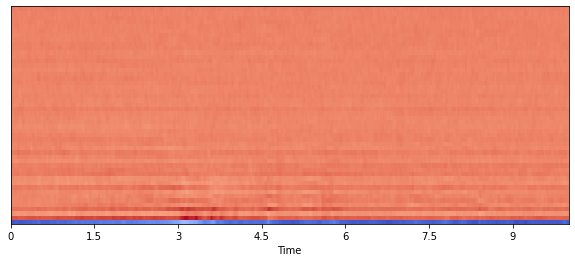

In [0]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(image, x_axis='time')

plt.show()


In [0]:
print(image)

[[-565.43475385 -557.29965153 -558.83258913 ... -531.08327432
  -540.11595961 -556.18886242]
 [  53.00685075   65.76373629   65.77614512 ...   46.33563601
    44.56948467   45.1494881 ]
 [ -19.97118824  -20.01821734  -24.30132646 ...  -29.47116422
   -25.33921917  -21.24872142]
 ...
 [   3.07657447    1.18287255    1.85418473 ...   -3.95820118
    -5.63646613   -3.06683168]
 [   3.16032941   -1.82445916    0.58269319 ...   -0.59997757
    -2.8545503     1.10208024]
 [   9.17324998    4.30781077    4.14713288 ...    5.82854552
     0.64415194    1.39399536]]


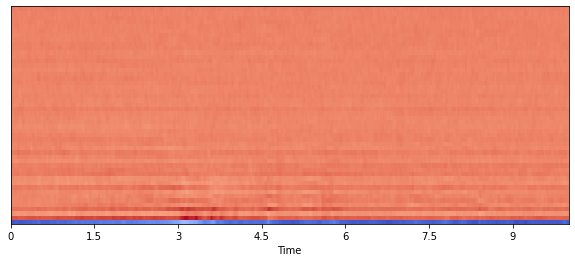

In [0]:
### 정규화하기
image = spec_to_image(image)

import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(image, x_axis='time')

plt.show()


In [0]:
print(image)

[[-7.3772175  -7.26910137 -7.28947423 ... -6.92068372 -7.04072879
  -7.2543389 ]
 [ 0.84191858  1.01145857  1.01162348 ...  0.75325763  0.72978535
   0.73749364]
 [-0.12796512 -0.12859014 -0.18551299 ... -0.25422052 -0.19930666
  -0.14494363]
 ...
 [ 0.1783414   0.15317396  0.16209575 ...  0.0848487   0.06254443
   0.09669507]
 [ 0.17945451  0.11320629  0.14519753 ...  0.12947975  0.0995163
   0.15210023]
 [ 0.25936669  0.19470463  0.19256921 ...  0.21491531  0.14601432
   0.1559798 ]]


In [0]:

### RGB로 바꾸기
image = np.expand_dims(image, axis=2)
image = np.repeat(image,3,axis=2)
image = np.expand_dims(image, axis=0) # 1 50 431 3

In [0]:
# 3223_record_with_app
predict = model.predict(image)
predict

array([[0.08031694, 0.9196831 ]], dtype=float32)

In [0]:
# 3223_record
predict = model.predict(image)
predict

array([[0.06382068, 0.93617934]], dtype=float32)

In [0]:
# very_quite.wav
predict = model.predict(image)
predict

array([[0.02356854, 0.9764315 ]], dtype=float32)

In [0]:
# 3223.mp3
predict = model.predict(image)
predict

array([[0.9984616 , 0.00153838]], dtype=float32)

# android 에서 얻은 데이터로 잘 판별하는지 확인
##(차원 모양도 확인)

In [0]:
csv_data = np.loadtxt('./data/test.csv', delimiter=",", dtype=np.float32)

In [0]:
csv_data.shape

(21550,)

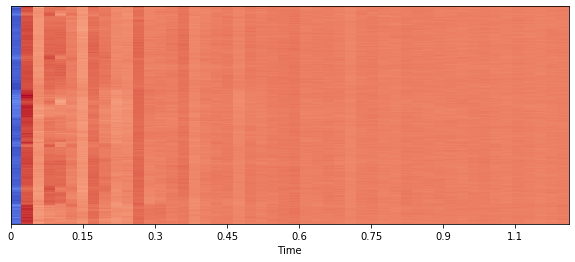

In [0]:
### 정규화하기
image2 = spec_to_image(image)
import matplotlib.pyplot as plt
import librosa
plt.figure(figsize=(10, 4))
librosa.display.specshow(csv_data.reshape((431,50)), x_axis='time')

plt.show()

In [0]:
csv_data

array([-604.47766  ,   71.982285 ,  -37.712437 , ...,    4.5778613,
          2.9321961,    8.038094 ], dtype=float32)

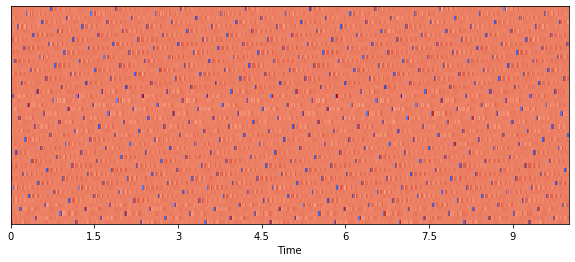

In [0]:
### 정규화하기
image2 = spec_to_image(image)
import matplotlib.pyplot as plt
import librosa
plt.figure(figsize=(10, 4))
librosa.display.specshow(csv_data.reshape((50,431)), x_axis='time')

plt.show()

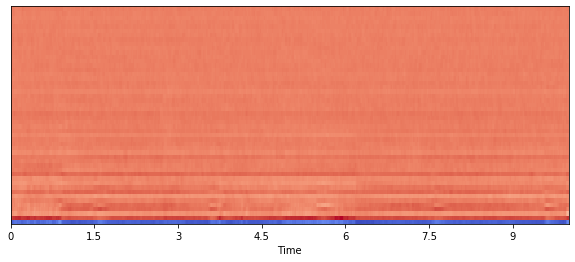

In [0]:
### 정규화하기
image2 = spec_to_image(image)
import matplotlib.pyplot as plt
import librosa
plt.figure(figsize=(10, 4))

librosa.display.specshow(np.transpose(csv_data.reshape((431,50))), x_axis='time')

plt.show()

In [0]:
predict = model.predict(image)

In [0]:
predict

array([[0.07714189, 0.9228582 ]], dtype=float32)

# TFLITE 사용하기

# model tflite export

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.load_weights("./model/20-0.9916_weight.hdf5")

In [0]:
model.save('./model/whole_model.hdf5')

In [0]:
import tensorflow as tf

# Convert the model.
# tf.contrib.lite.TFLiteConverter.from_keras_model_file
converter = tf.lite.TFLiteConverter.from_keras_model_file('./model/whole_model.hdf5')
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

# tfLite로 evaluate

In [0]:
import tensorflow as tf
# model_content, model_path
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [0]:
input_details[0]['shape']

array([  1,  50, 431,   3], dtype=int32)

In [0]:
output_details[0]['shape']

array([1, 2], dtype=int32)

In [0]:
image = get_mfcc('./data/test.wav', False)
### 정규화하기
image = spec_to_image(image)
print(image)
print(image.shape)
### RGB로 바꾸기
image = np.expand_dims(image, axis=2)
image = np.repeat(image,3,axis=2)
image = np.expand_dims(image, axis=0) # expand_dim
image = image.astype(np.float32)

(441022,) 44100
[[-7.07270737 -6.90194396 -6.68480958 ... -7.14677762 -6.60916644
  -6.127834  ]
 [ 0.88764865  1.06144225  1.25442877 ...  0.86500014  0.97754122
   1.19920208]
 [-0.26445568 -0.21307687 -0.20615043 ... -0.08421065 -0.60775526
  -1.00169602]
 ...
 [ 0.11574326  0.05000643  0.07246722 ...  0.10457819  0.11065497
   0.15414086]
 [ 0.03631999  0.10234122  0.13898971 ...  0.13849477  0.13443848
   0.11499193]
 [ 0.12697096  0.12774477  0.11360556 ...  0.10975929  0.16692212
   0.1734417 ]]
(50, 431)


In [0]:
image.shape

(1, 50, 431, 3)

In [0]:
type(image)

numpy.ndarray

In [0]:
import numpy as np
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()


In [0]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [0]:
tflite_results

array([[0.01127465, 0.98872536]], dtype=float32)

In [0]:
tf_results = model.predict(image)

In [0]:
tf_results

array([[0.07714189, 0.9228582 ]], dtype=float32)

# CSV 파일 tflite evaluate로 체크

In [0]:
csv_data = np.loadtxt('./data/test.csv', delimiter=",", dtype=np.float32)
np.transpose(csv_data.reshape((431,50)))

In [0]:
image = np.transpose(csv_data.reshape((431,50)))
### 정규화하기
image = spec_to_image(image)
print(image)
print(image.shape)
### RGB로 바꾸기
image = np.expand_dims(image, axis=2)
image = np.repeat(image,3,axis=2)
image = np.expand_dims(image, axis=0) # expand_dim
image = image.astype(np.float32)